In [21]:
# aws dependencies
# %pip install awswrangler

# # guara dependencies
# %pip install lightgbm
# %pip install shap
# %pip install optuna
# %pip install great_expectations
# %pip install unidecode

In [22]:
# general libs
import os
import re
import sys
import nltk 
import heapq
import boto3
import string
import difflib
import sagemaker
import numpy as np 
import pandas as pd
import seaborn as sn
import awswrangler as wr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')

# guara libs
from sklearn.pipeline import Pipeline
sys.path.append(os.path.dirname(os.getcwd())+'/src')
from get_data import GetData
from guara.modeling.supervised_modelz import SupervisedModelz

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load data

In [23]:
full_df = GetData().get_input_data()
full_df

Unverified HTTPS request is being made to host 'br-accamargo-rawdata-dev.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings


,rgh_x,identificador,laudo,data,resumo,cancer,rgh_y,dataliberacao,descrizione,codice,texto,testodiagnosicitotec
0,1341,3004888942H20-028890,H20-028890,2020-11-12,[* Pólipo endometrial sem atipias.],0,1341,12/11/2020,PEÇA CIRÚRGICA,PC,1 Biópsia de pólipo endometrial: * Pólipo end...,<NA>
1,3166,3003664904H20-013662,H20-013662,2020-06-29,[*Adenocarcinoma endometrioide de endométrio c...,1,3166,29/06/2020,REVISAO DE CASO (LAMINA) EXTERNO,REV_EXT,Biópsia de endométrio (SPA20-26515): *Adenoca...,<NA>
2,3166,2003793224H20-014936,H20-014936,2020-07-20,[* Adenocarcinoma endometrioide do endométrio ...,1,3166,20/07/2020,PER-OPERATÓRIO PEÇA CIRÚRGICA,CONG_PEÇA,Útero: Corpo uterino: * Adenocarcinoma endom...,<NA>
3,4448,3004533927H20-024222,H20-024222,2020-10-07,"[* Pólipo endocervical sem atipias., * Pólipo ...",0,4448,07/10/2020,PEÇA CIRÚRGICA,PC,1 Pólipo de canal endocervical: * Pólipo endo...,<NA>
4,6220,1003913311H20-016310,H20-016310,2020-07-31,[* Pólipo endocervical sem atipias com metapla...,0,6220,31/07/2020,PEÇA CIRÚRGICA,PC,1 Pólipo de canal endocervical: * Pólipo endo...,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
6801,99038072,2003726850H20-014314,H20-014314,2020-07-05,[* Adenoma tubular com displasia de baixo grau...,0,99038072,05/07/2020,BIOPSIA,BIO,1 Pólipo de ceco * Adenoma tubular com displ...,<NA>
6802,99045982,3004819342H20-027967,H20-027967,2020-11-09,"[* Nevo melanocítico juncional atípico., * Nev...",0,99045982,09/11/2020,PEÇA CIRÚRGICA,PC,1 Pele de região de antebraço esquerdo: * ...,<NA>
6803,99046180,2004996510H20-030310,H20-030310,2020-11-23,"[* Gastrite crônica moderada, em mucosa de pad...",0,99046180,23/11/2020,BIOPSIA,BIO,1 Pólipo de corpo gástrico * Gastrite crôn...,<NA>
6804,99046318,2003975984H20-017150,H20-017150,2020-08-07,[* Cisto triquilemal.],0,99046318,07/08/2020,PEÇA CIRÚRGICA,PC,1 Produto de vulvectomia simples: * Cisto tri...,<NA>


# Definições

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

In [25]:
import nltk
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.util import bigrams
from nltk.misc import babelize_shell
from unidecode import unidecode
from nltk import tokenize

def GetYearBasis(X, col='dataliberacao'):
    assert isinstance(X, pd.DataFrame)

    dataset_list = []
    for year in sorted(set(X[col].dt.year)):
        X_aux = X.copy()
        X_aux[col] = pd.to_datetime(X[col])
        X_aux = X_aux[X_aux[col].dt.year == year]
        dataset_list.append(X_aux)
        
    return dataset_list


def processa_texto_(texto, return_ = 'string'):
    # stemmer = nltk.stem.RSLPStemmer()
    stemmer = nltk.stem.SnowballStemmer(language = 'portuguese')
    stopwords=nltk.corpus.stopwords.words('portuguese')
   


    # separa em palavras
    token = tokenize.word_tokenize(texto.lower(), language='portuguese')
    # retira stopwords
    token = [word for word in token if word not in stopwords]
    # retira palavras pre selecionadas
    #token = [word for word in token if len(word) > 2]
    # retira numeros 
    token = [ word if word.isalpha() else '#NUM' for word in token ]
    # tira caracteres especiais  e faz stemmizacao
    token = [unidecode(stemmer.stem(word)) for word in token]

    if return_ == 'string':
        return ' '.join(token)
    elif return_ == 'list':
        return token

    
class ProcessaTexto(BaseEstimator, TransformerMixin):

    def __init__(self, col):
        self.col=col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
     
        X['texto_tratado'] = X[self.col].replace('\§', ' ENTER ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '-'], '', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '\*'], ' ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace([ '\/', '\.', '\,', '\;'], ' punkt ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].apply(lambda x: processa_texto_(x))
        
        return X

In [26]:
class CountVectorizerPandas(BaseEstimator, TransformerMixin):
    """
    Performs bag of words on a column
    args:
        max_features: maximum number of features
    
    """  
    
    def __init__(self, max_features):
        self.cv = None
        self.max_features = max_features
        
    def fit(self, X, y=None):
        
        self.col = 'texto_tratado'
        
        self.cv =  CountVectorizer(max_features=self.max_features)
                           
        self.cv.fit(X[self.col])
        
        return self


    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        
        Xt = self.cv.transform(X[self.col]).todense()
        Xt = pd.DataFrame(Xt, columns = self.cv.get_feature_names(), index=X.index)
        
        return Xt  

# Pré-processamento

In [27]:
# split dos dados - 70% para treino e 30% para validação

x_aux, x_test, y_aux, y_test = train_test_split(
    full_df[['laudo','texto']], 
    full_df['cancer'], 
    train_size=0.9, 
    shuffle=True,
    random_state=123
    )

x_train, x_val, y_train, y_val = train_test_split(
    x_aux, 
    y_aux, 
    train_size=0.7, 
    shuffle=True,
    random_state=123
    )


# aplicar pipeline com transformações
pipe = Pipeline([
    ('preproc', ProcessaTexto('texto')),
    ('bag', CountVectorizerPandas(max_features=250))
])

x_train = pipe.fit_transform(x_train)
x_val = pipe.transform(x_val)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [28]:
print('x_train shape: ', x_train.shape, 'y_train shape: ', y_train.shape)
print('x_test shape: ', x_val.shape, 'y_test shape: ', y_val.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ', y_test.shape)

x_train shape:  (4287, 250) y_train shape:  (4287,)
x_test shape:  (1838, 250) y_test shape:  (1838,)
x_test shape:  (681, 2) y_test shape:  (681,)


In [29]:
x_train

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
4822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0
6425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0
3284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6126,2,3,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4443,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Treinamento do modelo

In [30]:
# modelagem
md = SupervisedModelz('lgbm', 'binary')

params = {
    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu',
    'is_unbalanced':'true',
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'max_depth': 20,
    'n_estimators': 500,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
 }

model = md.fit(x_train, x_val, y_train, y_val, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 1079, number of negative: 3208
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 4287, number of used features: 250
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.251691 -> initscore=-1.089613
[LightGBM] [Info] Start training from score -1.089613


Found `n_estimators` in params. Will use it instead of argument


Modelo treinado em 0.01 minutos 



Model best iteration: 500

BINARY_LOGLOSS loss:
Train: 0.0452
Val  : 0.0601


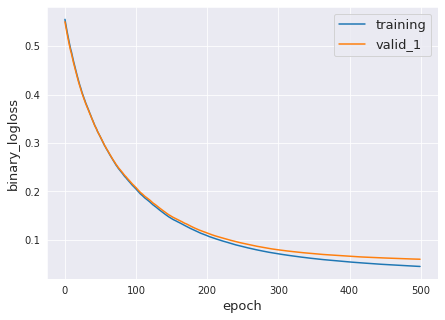

In [31]:
md.plot_train_info()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


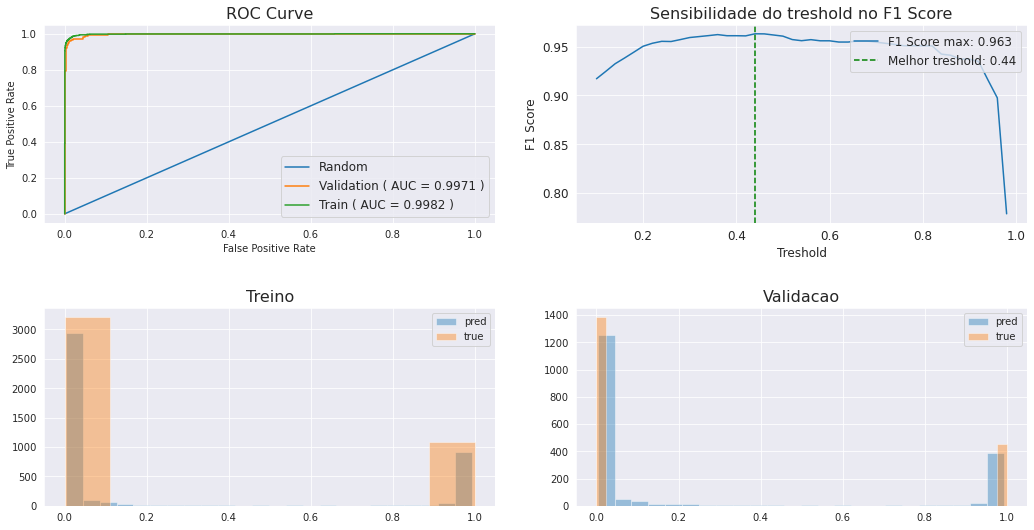

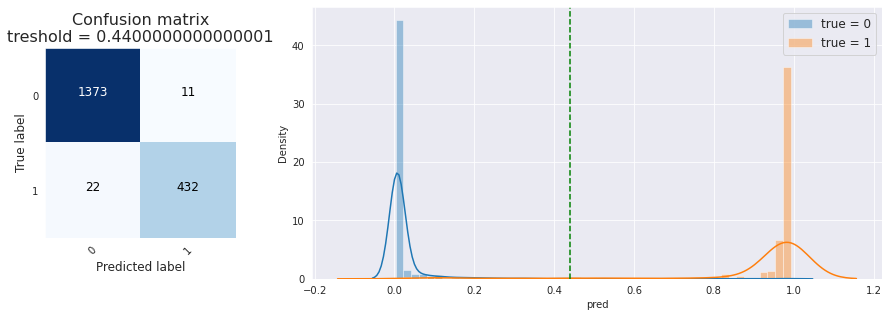


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1384
           1       0.98      0.95      0.96       454

    accuracy                           0.98      1838
   macro avg       0.98      0.97      0.98      1838
weighted avg       0.98      0.98      0.98      1838



In [32]:
ytrain_pred = md.predict(x_train)
yval_pred = md.predict(x_val)

md.evaluation_plots(y_train.values, ytrain_pred, y_val.values, yval_pred)

# Impacto e importância das variáveis

In [33]:
# shap
df_shap = md.init_shap(x_val)
df_shap.head()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
0,0.0,0.0,0.0,0.0,0.0,-0.165184,0.000588,0.0,0.008215,0.0,...,-0.000525,0.0,0.0,-0.024858,-0.000179,0.0,0.0,0.0,-0.001541,0.000512
1,0.0,0.0,0.0,0.0,0.0,-0.166448,0.000588,0.0,0.007591,0.0,...,-0.000526,0.0,0.0,-0.024392,-0.000212,0.0,0.0,0.0,-0.001541,0.000316
2,0.0,0.0,0.0,0.0,0.0,-0.147021,0.000588,0.0,0.039217,0.0,...,-0.000413,0.0,0.0,-0.017932,-0.000212,0.0,0.0,0.0,-0.001512,0.000736
3,0.0,0.0,0.0,0.0,0.0,-0.163193,-0.001366,0.0,0.007592,0.0,...,-0.000508,0.0,0.0,-0.025939,-0.001683,0.0,0.0,0.0,-0.001541,0.000736
4,0.0,0.0,0.0,0.0,0.0,4.620022,0.001367,0.0,0.007410,0.0,...,-0.000234,0.0,0.0,-0.011135,-0.001683,0.0,0.0,0.0,0.031365,0.000688


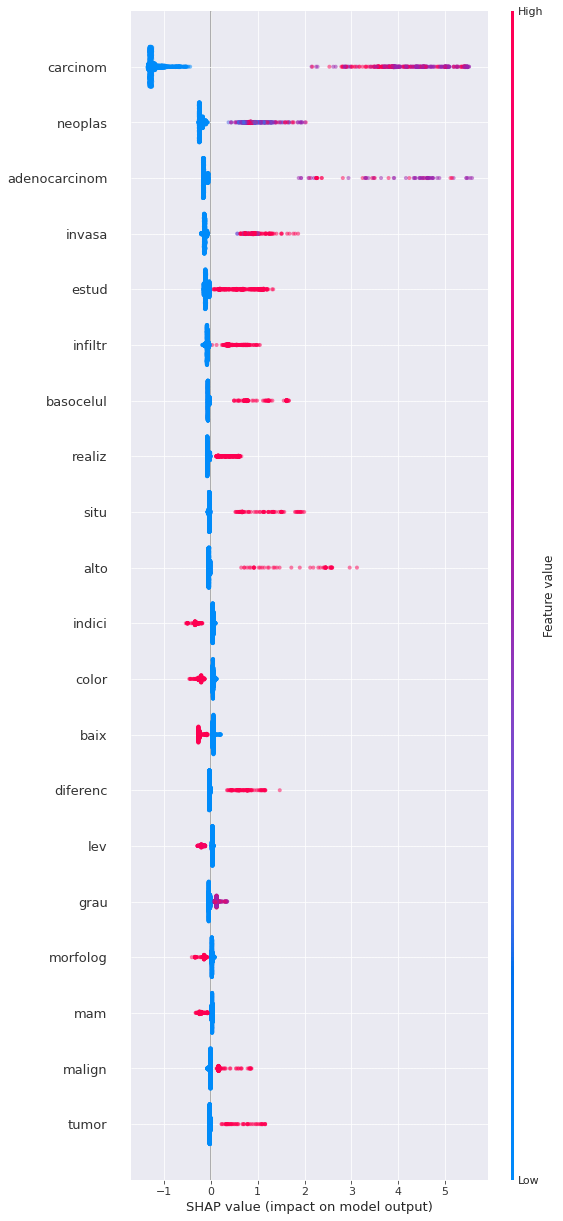

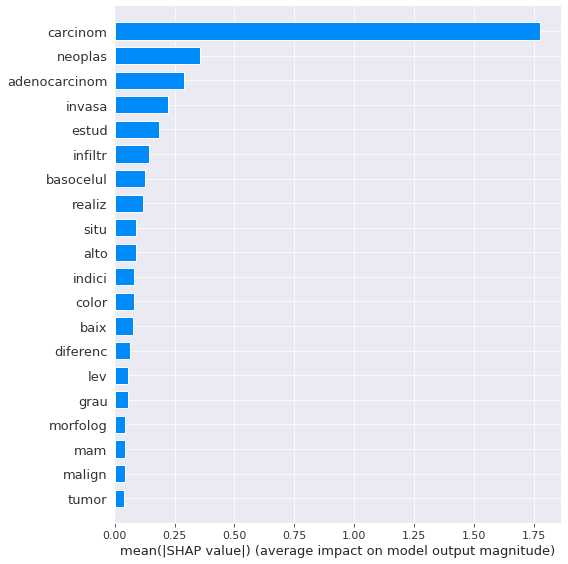

In [34]:
importance = md.shap_importance(x_val)

In [35]:
importance

carcinom         1.775832
neoplas          0.357790
adenocarcinom    0.287997
invasa           0.221180
estud            0.184490
                   ...   
foveol           0.000000
pern             0.000000
fundic           0.000000
gastric          0.000000
acentu           0.000000
Length: 250, dtype: float64

# Salvando o modelo treinado

In [36]:
# definição para salvar pipeline e modelo 

import pytz
import joblib
from datetime import datetime as dt

def save_pipe_and_model(
    artifacts_path,
    pipeline,
    model
    ):
        print(f'SAVING ----------------\n ')
        exp_name = dt.now(tz=pytz.timezone('America/Sao_Paulo')).strftime('%Y%m%d-%H%M%S')
        
        path_to_experiment = artifacts_path + exp_name
        model_path = f'{path_to_experiment}/model_{exp_name}.joblib'
        pipeline_path = f'{path_to_experiment}/pipeline_{exp_name}.joblib'
        
        print(f'Creating experiment directory in {path_to_experiment}')
        os.mkdir(path_to_experiment)
        
        joblib.dump(pipeline, pipeline_path )
        print(f'Pipeline saved in: {pipeline_path}')
        
        joblib.dump(model, model_path )
        print(f'Model saved in: {model_path}')

In [37]:
save_pipe_and_model(
    artifacts_path=os.path.dirname(os.getcwd()) + '/artifacts/experiments/',
    pipeline=pipe,
    model=md
    )

SAVING ----------------
 
Creating experiment directory in /home/ec2-user/SageMaker/accamargo-poc-laudos/artifacts/experiments/20210712-133359
Pipeline saved in: /home/ec2-user/SageMaker/accamargo-poc-laudos/artifacts/experiments/20210712-133359/pipeline_20210712-133359.joblib
Model saved in: /home/ec2-user/SageMaker/accamargo-poc-laudos/artifacts/experiments/20210712-133359/model_20210712-133359.joblib
